# Filtering Foursquare Data

In this notebook we process a full data set with Foursquare venues and check-ins. It's [available here](https://sites.google.com/site/yangdingqi/home/foursquare-dataset). We keep only the venues and check-ins within our areas of interest defined in the previous notebook.

## Preamble

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(context='notebook', font='Fira Sans', style='white', palette='plasma')

In [2]:
import pandas as pd
import geopandas as gpd

We use `dask.dataframe` to process huge text files.

In [3]:
import dask.dataframe as dd

Here we load the results of the previous notebook.

In [4]:
areas = gpd.read_file('output/relevant_area.geo.json')

In [5]:
grid = gpd.read_file('output/relevant_grid.geo.json')

In [6]:
bbox = areas.total_bounds
bbox

array([ 1.8467312, 41.263409 ,  2.2964971, 41.5749847])

## Venue Processing

Here we analyze venues (or Points of Interest). 

In [7]:
pois = dd.read_csv('4sq_2019/raw_POIs.txt', sep='\t', names=['venue_id', 'lat', 'lon', 'category', 'country'])

In [8]:
pois.head()

,venue_id,lat,lon,category,country
0,3fd66200f964a52000e61ee3,40.729209,-73.998753,Post Office,US
1,3fd66200f964a52000e71ee3,40.733596,-74.003139,Jazz Club,US
2,3fd66200f964a52000e81ee3,40.758102,-73.975734,Gym,US
3,3fd66200f964a52000ea1ee3,40.732456,-74.003755,Indian Restaurant,US
4,3fd66200f964a52000ec1ee3,42.345907,-71.087001,Indian Restaurant,US


In [9]:
pois_in_bbox = pois[pois.lon.between(bbox[0], bbox[2]) & pois.lat.between(bbox[1], bbox[3])].compute()
pois_in_bbox.sample(5)

,venue_id,lat,lon,category,country
957884,4d6e27f0ffedf04d6f825ec5,41.387720,2.167179,Office,ES
322784,4cdc0d4ac409b60c813ed81a,41.494001,2.029467,Building,ES
876329,4c77ef6c1e71a1cd7d130eea,41.403789,2.156925,Plaza,ES
48179,5054c945e4b04495bcebb5a2,41.404568,2.172361,Cocktail Bar,ES
886534,50ce03cde4b04f44e82697fc,41.411920,2.162002,Football Stadium,ES


In [10]:
len(pois_in_bbox)

25339

Text(0.5, 0, '# of Venues (POIs)')

/home/egraells/miniconda3/envs/iotwins_foursquare/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/egraells/miniconda3/envs/iotwins_foursquare/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


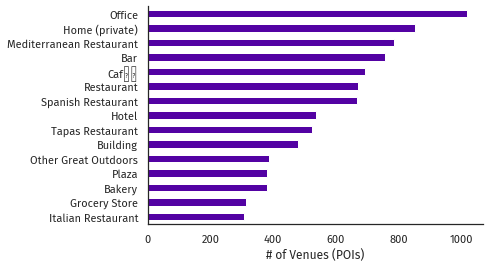

In [11]:
ax = pois_in_bbox.category.value_counts().head(15).sort_values().plot(kind='barh')
sns.despine(ax=ax)
ax.set_xlabel('# of Venues (POIs)')

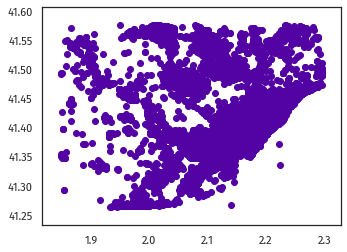

In [12]:
pois_gdf = gpd.GeoDataFrame(pois_in_bbox[['venue_id', 'category']],
                            geometry=gpd.points_from_xy(pois_in_bbox.lon, pois_in_bbox.lat),
                            crs=areas.crs)
pois_gdf.plot()

In [13]:
pois_gdf_amb = gpd.sjoin(pois_gdf, grid[['geometry',]], op='within', how='inner')
pois_gdf_amb

,venue_id,category,geometry,index_right
69289,4ad0e340f964a520c7da20e3,Southern / Soul Food Restaurant,POINT (2.15161 41.39223),2192
83087,4adcda4bf964a520873f21e3,Hotel,POINT (2.15006 41.39436),2192
83093,4adcda4cf964a520903f21e3,Hotel,POINT (2.15351 41.39404),2192
83145,4adcda4df964a520084021e3,Cocktail Bar,POINT (2.15427 41.39277),2192
83155,4adcda4df964a520164021e3,Beer Garden,POINT (2.15316 41.39503),2192
...,...,...,...,...
754754,523816c411d2e48e8a26b0aa,Factory,POINT (1.98903 41.46473),1391
775014,524012d811d22f52076ace02,Plane,POINT (2.08621 41.29014),2882
875672,527601a211d21ebf3efe796a,Tennis Court,POINT (1.99406 41.28381),477
990148,52cfeafc498e897f5c116008,Home (private),POINT (1.95391 41.41971),1069


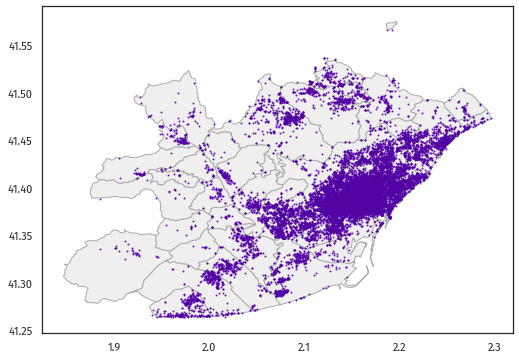

In [14]:
ax = areas.plot(figsize=(16, 6), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
pois_gdf_amb.plot(ax=ax, markersize=1, alpha=0.8)

In [15]:
pois_grid = gpd.sjoin(pois_gdf, grid[['geometry',]], op='within', how='inner')


In [16]:
pois_grid.head()

,venue_id,category,geometry,index_right
69289,4ad0e340f964a520c7da20e3,Southern / Soul Food Restaurant,POINT (2.15161 41.39223),2192
83087,4adcda4bf964a520873f21e3,Hotel,POINT (2.15006 41.39436),2192
83093,4adcda4cf964a520903f21e3,Hotel,POINT (2.15351 41.39404),2192
83145,4adcda4df964a520084021e3,Cocktail Bar,POINT (2.15427 41.39277),2192
83155,4adcda4df964a520164021e3,Beer Garden,POINT (2.15316 41.39503),2192


In [17]:
grid_n_pois = pois_grid.groupby('index_right').size()
grid_n_pois.name = 'poi_count'

/home/egraells/miniconda3/envs/iotwins_foursquare/lib/python3.8/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/home/egraells/miniconda3/envs/iotwins_foursquare/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Text(0.5, 1, '# of POIs in the Barcelona Metropolitan Area (Foursquare data)')

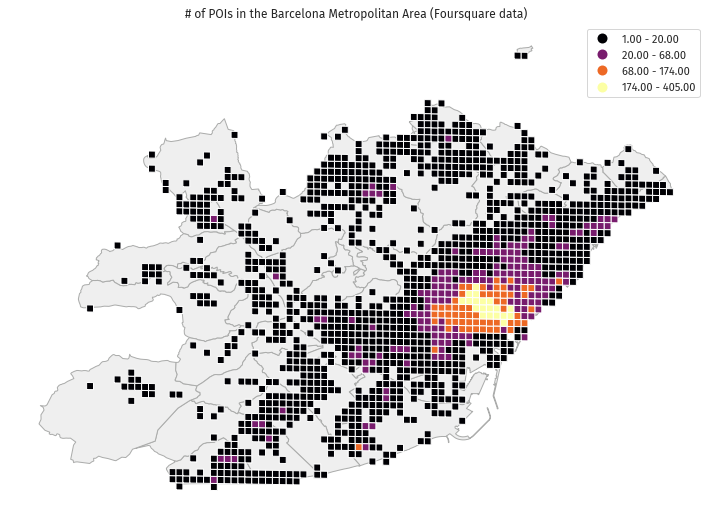

In [18]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
grid.join(grid_n_pois).dropna().plot(column='poi_count', cmap='inferno', k=4, scheme='Fisher_Jenks', ax=ax, legend=True)
ax.set_axis_off()
ax.set_title('# of POIs in the Barcelona Metropolitan Area (Foursquare data)')

## Check-Ins

In [19]:
check_ins = dd.read_csv('4sq_2019/raw_Checkins_anonymized.txt', sep='\t', names=['user_id', 'venue_id', 'datetime', 'utc_offset'])
check_ins.head()

,user_id,venue_id,datetime,utc_offset
0,546830,4f5e3a72e4b053fd6a4313f6,Tue Apr 03 18:00:06 +0000 2012,240
1,822121,4b4b87b5f964a5204a9f26e3,Tue Apr 03 18:00:07 +0000 2012,180
2,2277773,4a85b1b3f964a520eefe1fe3,Tue Apr 03 18:00:08 +0000 2012,-240
3,208842,4b4606f2f964a520751426e3,Tue Apr 03 18:00:08 +0000 2012,-300
4,1139878,4d9254ef62ad5481fa6e6a4b,Tue Apr 03 18:00:08 +0000 2012,-180


In [20]:
amb_check_ins = check_ins[check_ins.venue_id.isin(pois_gdf_amb.venue_id)].compute()
amb_check_ins.shape

(167017, 4)

In [21]:
amb_check_ins.head()

,user_id,venue_id,datetime,utc_offset
130,1597907,4d9b7366b2aaa093259f7082,Tue Apr 03 18:00:43 +0000 2012,120
278,106998,4adcda60f964a520934421e3,Tue Apr 03 18:01:23 +0000 2012,120
377,1101077,4bac7462f964a520d4f53ae3,Tue Apr 03 18:01:47 +0000 2012,120
382,1218854,4adcda60f964a520934421e3,Tue Apr 03 18:01:49 +0000 2012,120
433,1648478,4dfc7683227185f38b94d41d,Tue Apr 03 18:02:02 +0000 2012,120


In [22]:
user_counts = amb_check_ins.user_id.value_counts()
user_counts.describe()

count    21778.000000
mean         7.669070
std         24.900649
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1297.000000
Name: user_id, dtype: float64

In [23]:
venue_counts = amb_check_ins.venue_id.value_counts()
venue_counts.name = 'popularity'
venue_counts.describe()

count    22678.000000
mean         7.364715
std         46.766547
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       3975.000000
Name: popularity, dtype: float64

In [24]:
venues = pois_gdf_amb.join(venue_counts, on='venue_id').dropna()
venues.shape, pois_gdf_amb.shape

((24763, 5), (24763, 4))

In [25]:
venues.groupby('index_right')['popularity'].sum()

index_right
2       109
7         1
15        1
16        4
17       16
       ... 
3840     17
3841     22
3842      9
3844      2
3845      2
Name: popularity, Length: 1710, dtype: int64

In [26]:
top_popular = venues.sort_values('popularity', ascending=False).head(15)#.to_text()

Text(0.5, 0, 'Popularity')

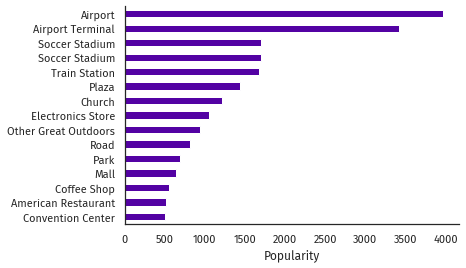

In [27]:
ax = top_popular[['category', 'popularity']].set_index('category').popularity.sort_values(ascending=True).plot(kind='barh', legend=False)
sns.despine(ax=ax)
ax.set_ylabel('')
ax.set_xlabel('Popularity')

Text(0.5, 1, 'Popularity of Cells in the Barcelona Metropolitan Area (Foursquare data)')

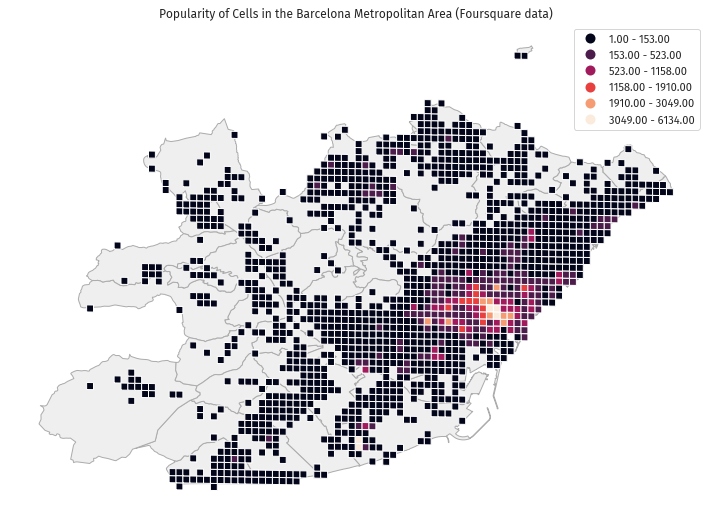

In [28]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
grid.join(venues.groupby('index_right')['popularity'].sum()).dropna().plot(column='popularity', k=6, scheme='Fisher_Jenks', ax=ax, legend=True)
ax.set_axis_off()
ax.set_title('Popularity of Cells in the Barcelona Metropolitan Area (Foursquare data)')

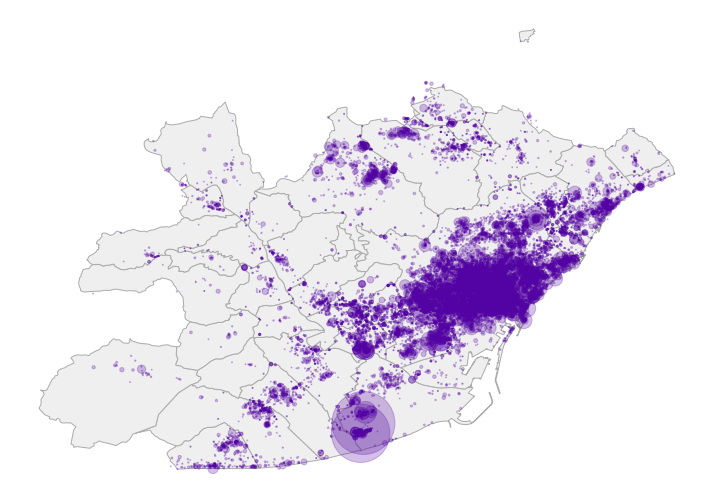

In [29]:
ax = areas.plot(figsize=(18, 9), edgecolor='#abacab', facecolor='#efefef', linewidth=1)
venues.plot(ax=ax, alpha=0.25, markersize='popularity')
ax.set_axis_off()

## Data Export

Here we save the relevant information, i.e., venues and check-ins in the areas of interest.

In [30]:
amb_check_ins.to_csv('output/relevant_check_ins.csv.gz')

In [31]:
pois_grid.to_file('output/relevant_pois.json', driver='GeoJSON')